In [1]:
%load_ext autoreload

In [1]:
# pl packages
import argparse
import torch
from pytorch_lightning.utilities.seed import seed_everything

# python packages
import os
import pandas as pd

os.chdir('../')
import sys

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

# single cell packages
import scanpy as sc
from scvi import REGISTRY_KEYS

Global seed set to 0


In [2]:
# %autoreload 2
# own packages
from feature_attribution_sc.models.scgen_models import SCGENCustom

In [3]:
batch_size=2048

threshold=0.5
# data_path='/home/icb/yuge.ji/projects/feature-attribution-sc/'
data_path='/home/yuge/feature-attribution-sc'
CHECKPOINT_PATH=f'{data_path}/trained_models/scgen/'
feature_importance=f'{data_path}/outputs/baselines/task1_random.csv'
max_epochs=500
early_stopping=True
patience=10

In [4]:
# GET GPU AND ARGS
if torch.cuda.is_available():
    print(f'CUDA_VISIBLE_DEVICES: {os.environ["CUDA_VISIBLE_DEVICES"]}')

In [5]:
# GET DATA
adata = sc.read(f'{data_path}/datasets/scgen_norman19.h5ad')

In [6]:
# FIX SEED FOR REPRODUCIBILITY
seed_everything(90)

Global seed set to 90


90

In [7]:
# GET MODEL
SCGENCustom.setup_anndata(adata)

In [8]:
model = SCGENCustom(adata, feature_importance=pd.read_csv(feature_importance), threshold=threshold)

In [9]:
# CHECKPOINT CALLBACK
CHECKPOINT_PATH = CHECKPOINT_PATH + feature_importance.split('/')[-1].split('.')[
    0] + '_' + str(threshold) + '_checkpoints.pt'  # set checkpoint path
print(f'CHECKPOINT_PATH: {CHECKPOINT_PATH}')

model.save(CHECKPOINT_PATH, overwrite=True)  # save model to checkpoint

CHECKPOINT_PATH: /home/yuge/feature-attribution-sc/trained_models/scgen/task1_random_0.5_checkpoints.pt


## New

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import scgen
from feature_attribution_sc.explainers.mask import mask, generate_rankings

sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

Global seed set to 0
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()
2023-03-01 17:06:05.877659: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-01 17:06:05.877820: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-01 17:06:05.877825: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing librari

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.10.0 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.3 pynndescent==0.5.7


In [2]:
data_path='/home/yuge/feature-attribution-sc'

In [3]:
adata = sc.read(f'{data_path}/datasets/scgen_norman19.h5ad')

Sparsity before:

In [4]:
adata.X.nnz / (adata.shape[0] * adata.shape[1])

0.17375166983192716

Set up the model for training as usual.

In [37]:
scgen.SCGEN.setup_anndata(adata, batch_key='perturbation_name')
model = scgen.SCGEN(adata)

Pull out the tensor form of the data for passing to the model manually later:

In [6]:
batch_size = adata.shape[0]
scdl = model._make_data_loader(adata=adata, indices=list(range(adata.shape[0])), batch_size=batch_size)
batch = next(scdl.__iter__())

Mask data:

In [7]:
feature_importance = pd.read_csv(f'{data_path}/outputs/baselines/task1_random.csv')

In [8]:
rankings, gene_indices = generate_rankings(feature_importance)  # probably should generate gene indices from adata or idk?

In [9]:
%%time
masked_inpt = mask(batch['X'], batch['batch'], feature_importance, rankings, gene_indices, threshold=.5)

CPU times: user 1min 12s, sys: 5.82 s, total: 1min 18s
Wall time: 1min 11s


Add the masking to a layer in the adata.

In [10]:
adata.layers['masked_random_50'] = masked_inpt.numpy()

Since we masked with zeroes, let's look at the sparsity after.

In [11]:
np.count_nonzero(adata.layers['masked_random_50']) / (adata.shape[0] * adata.shape[1])

0.08563386829780334

### Pass to an existing model

In [12]:
batch['X'] = masked_inpt

In [14]:
# file = 'scgen_norman19_model1_shuffled'
# model = scgen.SCGEN.load(f'{data_path}/models/{file}', adata=adata)
# model

In [15]:
adata.layers['masked_random_50_pred'] = model.module.forward(batch, compute_loss=False)[1]['px'].detach().numpy()

#### Evaluate

In [16]:
example_pert = 'KLF1'  # condition with the most occurrences

TODO: run the full 30min diffexp when you have time

In [17]:
ctrl_adata = adata[adata.obs.perturbation_name.isin(['control', example_pert])]

sc.tl.rank_genes_groups(ctrl_adata, groupby='perturbation_name', reference='control', method='wilcoxon')

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [18]:
diff_genes = ctrl_adata.uns['rank_genes_groups']['names'][example_pert]
print(diff_genes[:10])

['TMSB10' 'HBZ' 'PNMT' 'KLF1' 'HBG2' 'HBA1' 'HBG1' 'EMP3' 'ANXA2' 'BLVRB']


In [19]:
pred = adata[adata.obs.perturbation_name == example_pert]
pred.X = pred.layers['masked_random_50_pred']
pred.obs['perturbation_name'] = 'pred'

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/tmp/ipykernel_152580/760896427.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pred.obs['perturbation_name'] = 'pred'


In [21]:
eval_adata = pred.concatenate(ctrl_adata)[:, diff_genes[:100]]

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [22]:
eval_adata.obs.perturbation_name.value_counts()

control    11835
pred        1954
KLF1        1954
Name: perturbation_name, dtype: int64

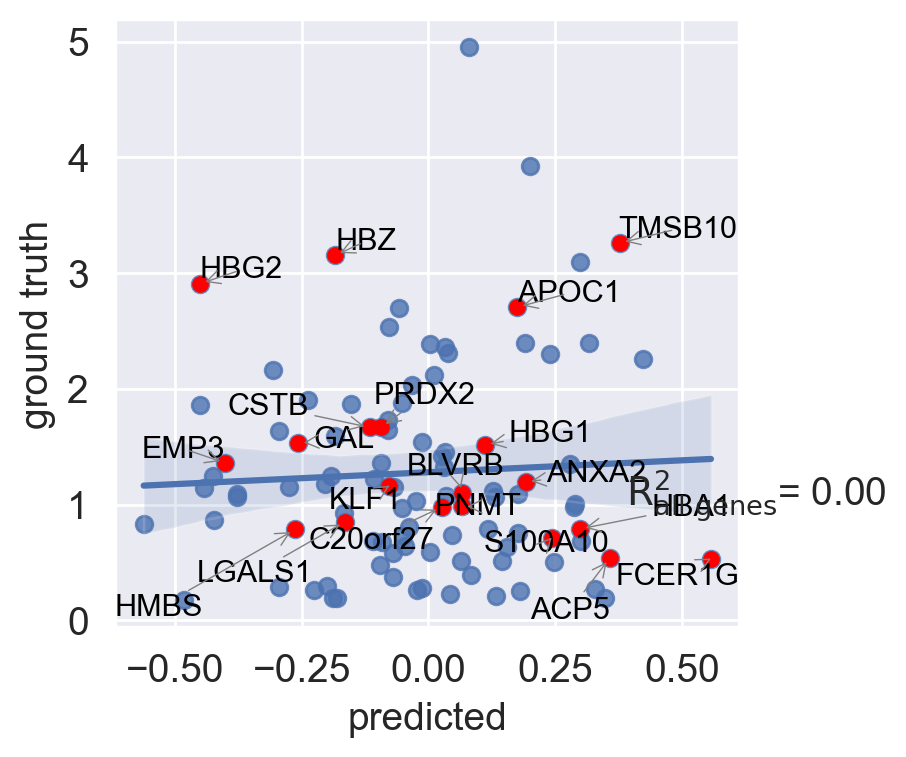

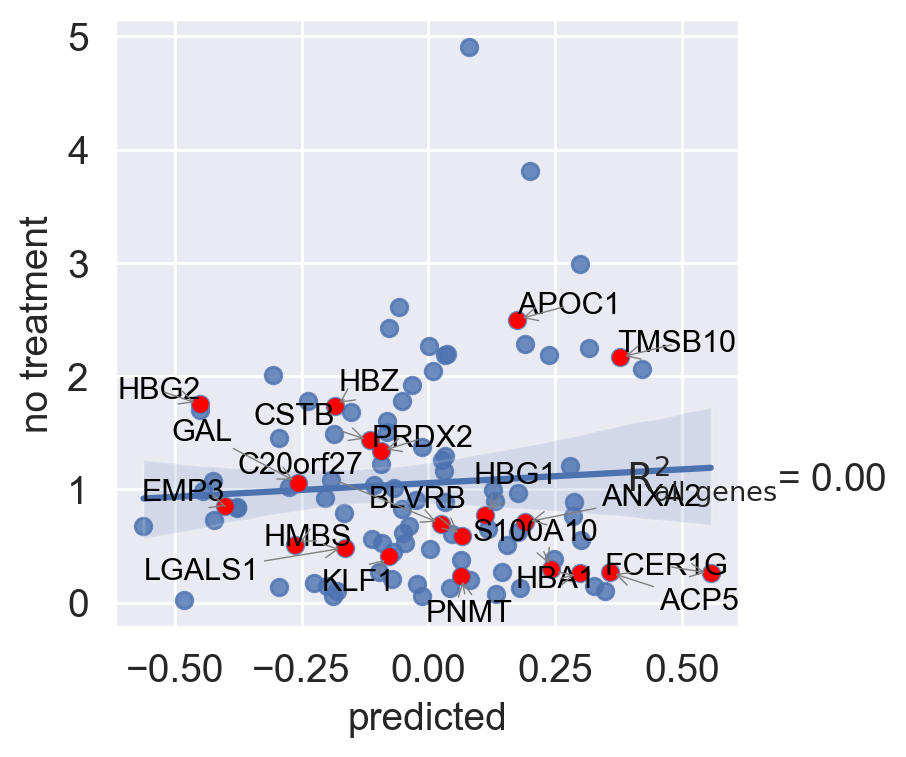

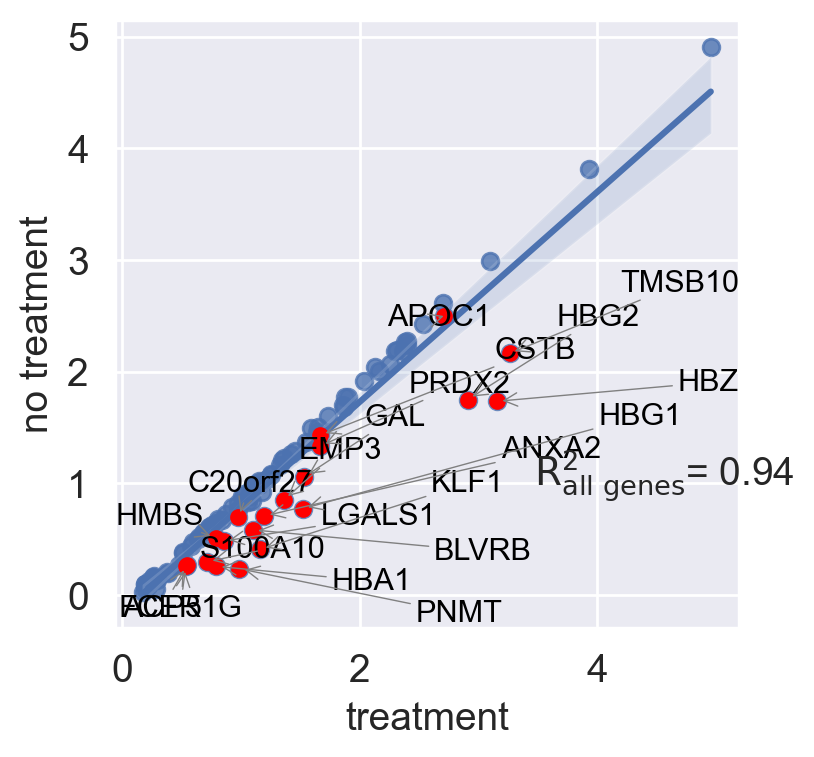

In [39]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={'x': 'pred', 'y': example_pert},
    gene_list=diff_genes[:20],
    labels={'x': 'predicted', 'y': 'ground truth'},
    show=True,
    legend=False
)
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={'x': 'pred', 'y': 'control'},
    gene_list=diff_genes[:20],
    labels={'x': 'predicted', 'y': 'no treatment'},
    show=True,
    legend=False
)
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={'x': example_pert, 'y': 'control'},
    gene_list=diff_genes[:20],
    labels={'x': 'treatment', 'y': 'no treatment'},
    show=True,
    legend=False
)

### Train a new model

In [70]:
adata.X = masked_inpt.numpy()

In [71]:
scgen.SCGEN.setup_anndata(adata)
model = scgen.SCGEN(adata)

In [72]:
# TRAIN
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=False,
#         early_stopping_patience=25
)

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU ava

Epoch 2/100:   1%|█▊                                                                                                                                                                                  | 1/100 [03:27<5:42:54, 207.83s/it, loss=407, v_num=1]

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
